# 0. Install and Import Dependencies

In [1]:
# !pip list

In [2]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

/Users/dennislaw/lip_readingenv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7085157e-aba4-4a9f-8a72-b29d1c5d9c48
To: /Users/dennislaw/Downloads/lip_reading_model/data.zip
100%|████████████████████████████████████████| 423M/423M [00:25<00:00, 16.7MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [13]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [15]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = './data/s1/bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

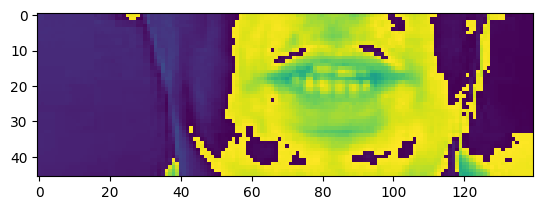

In [19]:
plt.imshow(frames[40])

In [20]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [21]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [22]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [23]:
from matplotlib import pyplot as plt

In [24]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
train = data.take(450)
test = data.skip(450)

In [25]:
len(test)
# len(data)

50

In [26]:
file_path = "./data/alignments/s1/bras7s.align"  # Replace with the file path you want to check

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")


The file './data/alignments/s1/bras7s.align' exists.


In [27]:
frames, alignments = data.as_numpy_iterator().next()

In [28]:
len(frames)

2

In [29]:
sample = data.as_numpy_iterator()

In [30]:
val = sample.next(); val[0]

array([[[[[ 1.4347187 ],
          [ 1.397931  ],
          [ 1.3243557 ],
          ...,
          [ 0.3678766 ],
          [ 0.29430127],
          [ 0.29430127]],

         [[ 1.508294  ],
          [ 1.4347187 ],
          [ 1.3243557 ],
          ...,
          [ 0.3678766 ],
          [ 0.29430127],
          [ 0.29430127]],

         [[ 1.4715064 ],
          [ 1.4715064 ],
          [ 1.4347187 ],
          ...,
          [ 0.33108893],
          [ 0.29430127],
          [ 0.29430127]],

         ...,

         [[ 1.0300545 ],
          [ 1.0300545 ],
          [ 1.0300545 ],
          ...,
          [ 0.07357532],
          [ 0.07357532],
          [ 0.07357532]],

         [[ 0.99326676],
          [ 0.99326676],
          [ 0.99326676],
          ...,
          [ 0.03678766],
          [ 0.03678766],
          [ 0.03678766]],

         [[ 0.99326676],
          [ 0.99326676],
          [ 0.99326676],
          ...,
          [ 0.03678766],
          [ 0.03678766],
          

In [31]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.380852699279785]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

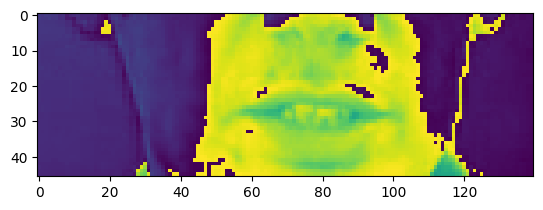

In [32]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [33]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white with s six please'>

# 3. Design the Deep Neural Network

In [34]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [35]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [36]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [38]:
5*17*75

6375

In [39]:
yhat = model.predict(val[0])

1/1 [==============================] - 2s 2s/step


In [40]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuukkkuuuuuuuuuuuuuuuuuuuuu    uuuuuuuuuuuuuuuuuuukkkuuuuuuuuuuuuu         '>

In [41]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuukkkuuuuuuuuuuuuuuuuuuuuu    uuuuuuuuuuuuuuuuuuukkkuuuuuuuuuuuuu         '>

In [42]:
model.input_shape

(None, 75, 46, 140, 1)

In [43]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [44]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [45]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [46]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [47]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
, loss=CTCLoss)

In [48]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [49]:
schedule_callback = LearningRateScheduler(scheduler)

In [50]:
example_callback = ProduceExample(test)

In [51]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [52]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=f108a026-024b-4135-a3eb-58a174d969b0
To: /Users/dennislaw/Downloads/lip_reading_model/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:05<00:00, 16.5MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [53]:
model.load_weights('models/checkpoint')

In [54]:
test_data = test.as_numpy_iterator()

In [55]:
sample = test_data.next()

In [56]:
yhat = model.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [57]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green with t two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green by x one again'>]

In [58]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [59]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay green with t two please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green by x one again'>]

# Test on a Video

In [60]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [61]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [62]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 797ms/step


In [63]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [64]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [75]:
# # Define Cantonese Initials
# cantonese_initials = [
#     'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'ng', 'h', 'gw', 'kw', 'w', 'z', 'c', 's', 'j'
# ]

# # Define Cantonese Finals
# cantonese_finals = [
#     'a', 'aa', 'i', 'u', 'e', 'o', 'ai', 'au', 'ei', 'ou', 'iu', 'ui', 'eon', 'oeng', 'aai', 'aau', 'eoi', 'm',
#     'ng', 'si', 'yi'
# ]

# # Define Cantonese Tones
# cantonese_tones = [
#     '1', '2', '3', '4', '5', '6', '7', '8', '9'
# ]

# # Create Cantonese Phonemes
# cantonese_phonemes = []
# for initial in cantonese_initials:
#     for final in cantonese_finals:
#         for tone in cantonese_tones:
#             cantonese_phonemes.append(f"{initial}{final}{tone}")

# # Display the Cantonese Phoneme Set
# print("Cantonese Phoneme Set:")
# for phoneme in cantonese_phonemes:
#     print(phoneme)


Cantonese Phoneme Set:
ba1
ba2
ba3
ba4
ba5
ba6
ba7
ba8
ba9
baa1
baa2
baa3
baa4
baa5
baa6
baa7
baa8
baa9
bi1
bi2
bi3
bi4
bi5
bi6
bi7
bi8
bi9
bu1
bu2
bu3
bu4
bu5
bu6
bu7
bu8
bu9
be1
be2
be3
be4
be5
be6
be7
be8
be9
bo1
bo2
bo3
bo4
bo5
bo6
bo7
bo8
bo9
bai1
bai2
bai3
bai4
bai5
bai6
bai7
bai8
bai9
bau1
bau2
bau3
bau4
bau5
bau6
bau7
bau8
bau9
bei1
bei2
bei3
bei4
bei5
bei6
bei7
bei8
bei9
bou1
bou2
bou3
bou4
bou5
bou6
bou7
bou8
bou9
biu1
biu2
biu3
biu4
biu5
biu6
biu7
biu8
biu9
bui1
bui2
bui3
bui4
bui5
bui6
bui7
bui8
bui9
beon1
beon2
beon3
beon4
beon5
beon6
beon7
beon8
beon9
boeng1
boeng2
boeng3
boeng4
boeng5
boeng6
boeng7
boeng8
boeng9
baai1
baai2
baai3
baai4
baai5
baai6
baai7
baai8
baai9
baau1
baau2
baau3
baau4
baau5
baau6
baau7
baau8
baau9
beoi1
beoi2
beoi3
beoi4
beoi5
beoi6
beoi7
beoi8
beoi9
bm1
bm2
bm3
bm4
bm5
bm6
bm7
bm8
bm9
bn1
bn2
bn3
bn4
bn5
bn6
bn7
bn8
bn9
bng1
bng2
bng3
bng4
bng5
bng6
bng7
bng8
bng9
bsi1
bsi2
bsi3
bsi4
bsi5
bsi6
bsi7
bsi8
bsi9
byi1
byi2
byi3
byi4
byi5
byi6
byi7
byi8
b

In [101]:
# len(cantonese_finals)

22

In [107]:
# Define your set of Cantonese phonemes using patterns for initials, finals, and tones
cantonese_phonemes = {}

# Generalize initial patterns (e.g., 'b' for labial, 'd' for dental, etc.)
initials = ['b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'ng', 'h', 'gw', 'kw', 'w', 'z', 'c', 's', 'j']
finals = ['aa', 'aai', 'aau', 'aam', 'aan', 'aang', 'aap', 'aat', 'aak', 'ai', 'au', 'am', 'an', 'ang', 'ap', 'at', 'ak', 'e', 'ei', 'eu', 'em', 'eng', 'ep', 'ek', 'i', 'iu', 'im', 'in', 'ing', 'ip', 'it', 'ik', 'o', 'oi', 'ou', 'on', 'ong', 'ot', 'ok', 'u', 'ui', 'un', 'ung', 'ut', 'uk', 'oe', 'oey', 'oen', 'oeng', 'oet', 'oek', 'y', 'yn', 'yn', 'm', 'ng']
tones = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

# Generate the Cantonese phonemes using combinations of initials, finals, and tones
for initial in initials:
    for final in finals:
        for tone in tones:
            # Create the key as a combination of initial, final, and tone
            key = initial + final + tone
            # Assign a unique integer representation for the key
            value = len(cantonese_phonemes)
            cantonese_phonemes[key] = value

# Test the mapping
sample_initial = 'b'
sample_final = 'aa'
sample_tone = '1'

# Use -1 as the separator
separator = -1

# Add separators
integer_representation = []

integer_representation.append(cantonese_phonemes.get(sample_initial + sample_final + sample_tone, -1))

# Add the separator
integer_representation.append(separator)

decoded_initial = sample_initial
decoded_final = sample_final
decoded_tone = sample_tone

print(f"Initial '{sample_initial}' + Final '{sample_final}' is represented as integer sequence: {integer_representation}")


Initial 'b' + Final 'aa' is represented as integer sequence: [0, -1]


In [104]:
cantonese_phonemes.get(sample_initial + sample_final + sample_tone, -1)

497

In [97]:
# # Define your set of Cantonese phonemes
# cantonese_phonemes = {
#     'b': {
#         'aa1': 0, 'aa2': 1, 'aa3': 2, 'aa4': 3, 'aa5': 4, 'aa6': 5,
#         'aai1': 6, 'aai2': 7, 'aai3': 8, 'aai4': 9, 'aai5': 10, 'aai6': 11,
#         # Add more finals and tones as needed
#     },
#     'p': {
#         'aa1': 12, 'aa2': 13, 'aa3': 14, 'aa4': 15, 'aa5': 16, 'aa6': 17,
#         # Add more finals and tones as needed
#     },
#     # Add more initials and their corresponding finals and tones
# }

# # Test the mapping
# sample_initial = 'b'
# sample_final = 'aa3'
# sample_tone = 2  # Convert the tone to a string if it's not already

# # Corrected code to access the integer representation
# integer_representation = cantonese_phonemes.get(sample_initial, {}).get(sample_final, -1)

# decoded_initial = sample_initial
# decoded_final = sample_final
# decoded_tone = sample_tone

# print(f"Initial '{sample_initial}' + Final '{sample_final}' + Tone '{sample_tone}' is represented as integer: {integer_representation}")


Initial 'b' + Final 'aa3' + Tone '2' is represented as integer: 2


In [84]:
# print(type(sample_initial))

<class 'str'>


In [96]:
# cantonese_phonemes.get(sample_initial, {}).get(sample_final, {})

{'aa1': 0,
 'aa2': 1,
 'aa3': 2,
 'aa4': 3,
 'aa5': 4,
 'aa6': 5,
 'aai1': 6,
 'aai2': 7,
 'aai3': 8,
 'aai4': 9,
 'aai5': 10,
 'aai6': 11}

In [98]:
# # Define your set of Cantonese phonemes
# cantonese_phonemes = {
#     'b': {
#         'aa1': 0, 'aa2': 1, 'aa3': 2, 'aa4': 3, 'aa5': 4, 'aa6': 5,
#         'aai1': 6, 'aai2': 7, 'aai3': 8, 'aai4': 9, 'aai5': 10, 'aai6': 11,
#         # Add more finals and tones as needed
#     },
#     'p': {
#         'aa1': 12, 'aa2': 13, 'aa3': 14, 'aa4': 15, 'aa5': 16, 'aa6': 17,
#         # Add more finals and tones as needed
#     },
#     # Add more initials and their corresponding finals and tones
# }

# # Use -1 as the separator
# separator = -1

# # Test the mapping
# sample_initial = 'b'
# sample_final = 'aa3'
# sample_tone = '2'  # Convert the tone to a string if it's not already

# # Add separators
# integer_representation = []

# # Add the initial
# integer_representation.append(cantonese_phonemes.get(sample_initial, {}).get(sample_final, -1))

# # Add the separator
# integer_representation.append(separator)

# # Add the final
# integer_representation.append(cantonese_phonemes.get(sample_initial, {}).get(sample_final, -1))

# decoded_initial = sample_initial
# decoded_final = sample_final
# decoded_tone = sample_tone

# print(f"Initial '{sample_initial}' + Final '{sample_final}' is represented as integer sequence: {integer_representation}")


Initial 'b' + Final 'aa3' is represented as integer sequence: [2, -1, 2]
